In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from pathlib import Path

In [2]:
iterations = 101000
SUBS_data_filename = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy')
#SUBS_data_filename = Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_101000.npy')

X_subs = np.load(SUBS_data_filename).astype('float32')

In [ ]:
kmax = 150
n = 90000

LRES_data_filename = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n}_k_{kmax}.npy')
Y_nwp = np.load(LRES_data_filename)

In [4]:
def generate_data(n, k, spinup, spacing, kmax=150, lres=False):
    N = iterations + 1
    # Regions
    fit_x, fit_y = slice(spinup, n + spinup - k), slice(spinup + k, n + spinup)
    prd_x, prd_y = slice(n + spinup, N - k), slice(n + spinup + k, N)

    # Data
    X_train, Y_train = X_subs[fit_x], X_subs[fit_y]
    X_test, Y_test = X_subs[prd_x], X_subs[prd_y]

    
    Y_lres = np.zeros_like(Y_test)
    if lres:
        if k>0:
            Y_lres = Y_nwp[k,spinup:-k,:]
        else:
            Y_lres = Y_nwp[k,spinup:,:]
        
    return X_train[::spacing], Y_train[::spacing], X_test[::spacing], Y_test[::spacing], Y_lres[::spacing]

# Fourier

In [4]:
from scipy.fftpack import fft2, ifft2, fftshift

In [5]:
iterations = 101000
HRES_data_filename = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_HRES_{iterations}.npz')
X_hres = np.load(HRES_data_filename)['sample'].astype('float32')
X_hres = np.array([X_hres[i].reshape((2**7+1,2**7+1)) for i in range(X_hres.shape[0])])

## 2D

In [6]:
def moving_average_2d_fft(time_series, window_size, stride):
    # Fourier transform along spatial dimensions for each time step
    fft_series = fftshift(fft2(time_series))
    times = []
    avg_fft = []
    
    t = 0
    while t + window_size < time_series.shape[0]:
        times.append(t)
        end_time = t + window_size
        avg_fft.append(np.average(np.abs(fft_series[t:end_time,:,:]),axis=0))
        t += stride
    return np.array(avg_fft), times

# Example usage
window_size = 10000
avg_fft, times = moving_average_2d_fft(X_hres, window_size, window_size)

In [7]:
global_min = np.inf
global_max = -np.inf

for i,res in enumerate(avg_fft):
    data = res
    global_min = min(global_min, np.min(data))
    global_max = max(global_max, np.max(data))

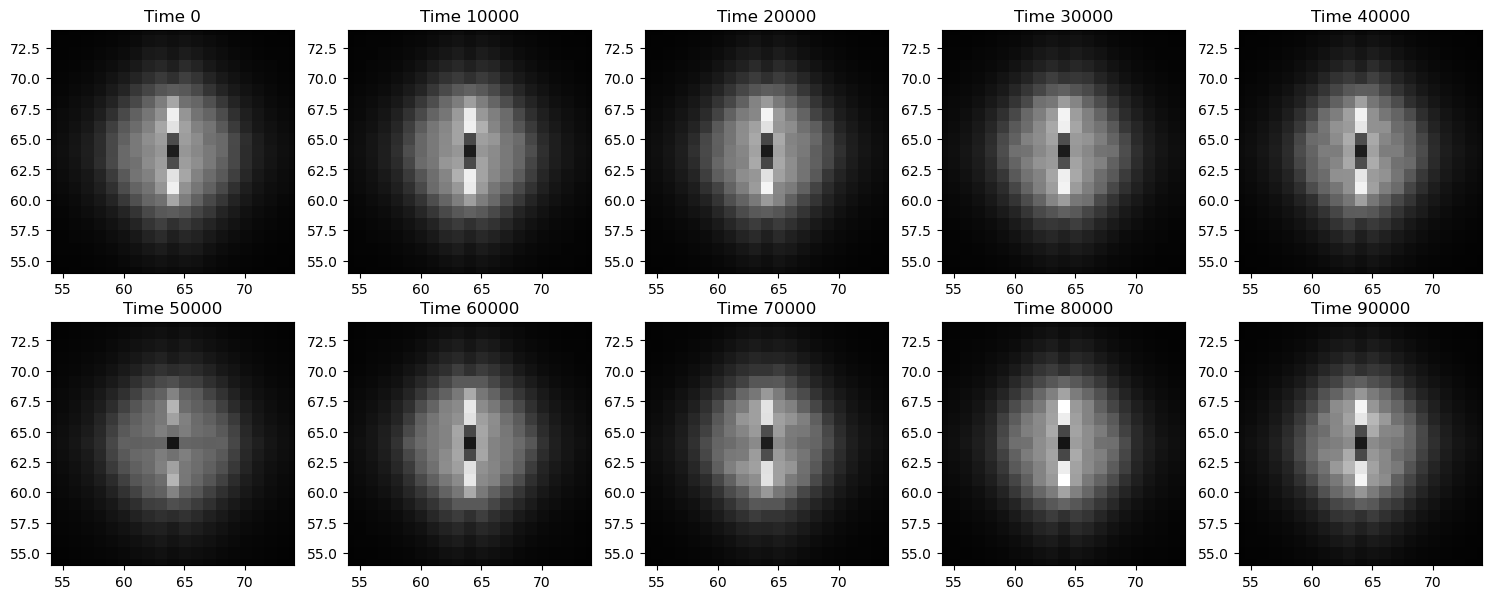

In [8]:
# Create a figure with subplots
yi, xi = 2,5
fig, axes = plt.subplots(yi, xi, figsize=(15, 6))  # Adjust the figsize as needed

delta = 10
# Loop over the first axis
for i, (res, t) in enumerate(zip(avg_fft, times)):
    row, col = i // xi, i % xi  # Determine the row and column for the subplot
    axes[row, col].imshow(res, cmap='gray', vmin=global_min, vmax=global_max)  # Plot the 2D slice
    axes[row, col].set_title(f'Time {t}')
    #axes[row, col].axis('off')
    axes[row, col].set_xlim([64-delta,64+delta])
    axes[row, col].set_ylim([64-delta,64+delta])

plt.tight_layout()
plt.show()

## Radial

In [9]:
# Compute the center of mass as the center of the 2D Fourier transform
center_x, center_y = 64, 64
max_size = center_x*2 + 1

# Create an array of radii
max_radius = min(center_x, center_y)  # Maximum radius is limited by the center position
radii = np.arange(0, max_radius)

# Initialize an array to store the radial profile
radial_profile = []

# Iterate over the radii
for i, r in enumerate(radii):
    # Create a binary mask of the circle with radius r centered at the origin
    y, x = np.ogrid[-center_y:max_size - center_y, -center_x:max_size - center_x]
    mask = (x**2 + y**2 <= (r+1)**2) & (x**2 + y**2 >= r**2)
    # Calculate the average magnitude within the circle
    radial_profile.append(mask)

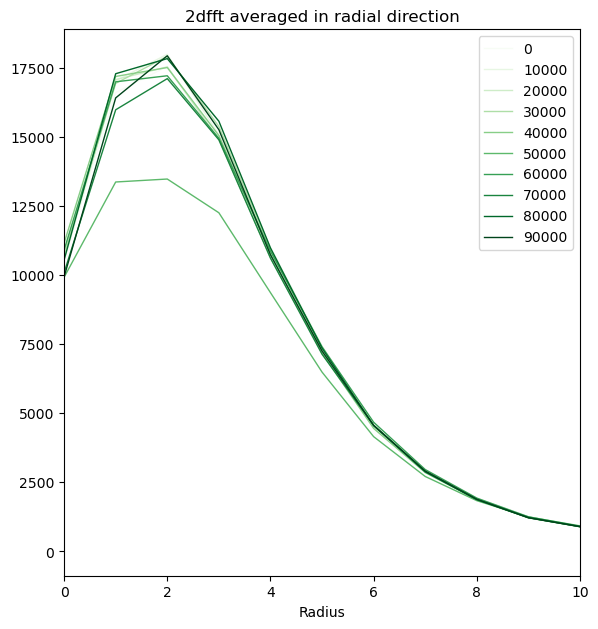

In [10]:
fig = plt.figure(figsize=(6,6))
from matplotlib.colors import LinearSegmentedColormap

colors = plt.cm.Greens(np.linspace(0, 1, len(avg_fft)))  # You can choose any colormap you like


# Loop over the first axis
for i, (res, t, color) in enumerate(zip(avg_fft, times, colors)):
    radial_res = np.array([np.mean(res[mask]) for mask in radial_profile])
    plt.plot(radii, radial_res, label=f'{t}', color=color, linewidth=1)

plt.legend()
plt.tight_layout()
plt.title("2dfft averaged in radial direction")
plt.xlim([0,10])
plt.xlabel("Radius")
plt.show()


# Forecast evaluation

In [6]:
def ensemble(n_ens, X_train, Y_train, X_test, Y_test, Y_lres):
    # Fit and Predict
    knn = KNeighborsRegressor(n_neighbors=n_ens, weights='distance')
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test).astype('float32')

    # Ensemble
    neigh_dist, neigh_ind = knn.kneighbors(X_test)
    ens_pred = Y_train[neigh_ind]

    # Sanity check
    inv_neigh_dist = 1 / neigh_dist
    ens_mean = np.sum(ens_pred*inv_neigh_dist[:,:,np.newaxis], axis=1)/np.sum(inv_neigh_dist, axis=1)[:,np.newaxis]
    print(np.linalg.norm(ens_mean - Y_pred))

    # Ensemble Spread
    # square root of average ensemble variance 

    # kNN
    ens_spread_knn = np.sqrt(np.mean(np.var(Y_pred[:,np.newaxis,:] - ens_pred, axis=1), axis=1))
    ens_rmse_knn = np.sqrt(np.mean((Y_pred - Y_test)**2, axis=1))
    #ens_bias = np.mean((Y_pred - Y_test), axis=1)

    # NWP
    ens_rmse_lres = np.sqrt(np.mean((Y_lres - Y_test)**2, axis=1))

    # Climatology
    Y_clm = np.mean(Y_test, axis=0)
    ens_spread_clm = np.std(Y_clm[np.newaxis,:] - Y_test, axis=1)
    ens_rmse_clm = np.sqrt(np.mean((np.mean(X_train, axis=0)[np.newaxis,:] - Y_test)**2, axis=1))

    # 
    return ens_spread_knn, ens_rmse_knn, ens_spread_clm, ens_rmse_clm, ens_rmse_lres

k = 150
n = 90000
spinup = 1001
spacing = 10

X_train, Y_train, X_test, Y_test, Y_lres = generate_data(n, k, spinup, spacing)

n_ens = 100
ens_spread, ens_rmse, ens_spread_clm, ens_rmse_clm, ens_rmse_lres = ensemble(n_ens, X_train, Y_train, X_test, Y_test, Y_lres)


0.0002445100925514009


/tmp/ipykernel_28922/3124079005.py:1: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


0.00029536442701940757
0.0002603099883849842
0.0002441212131935423


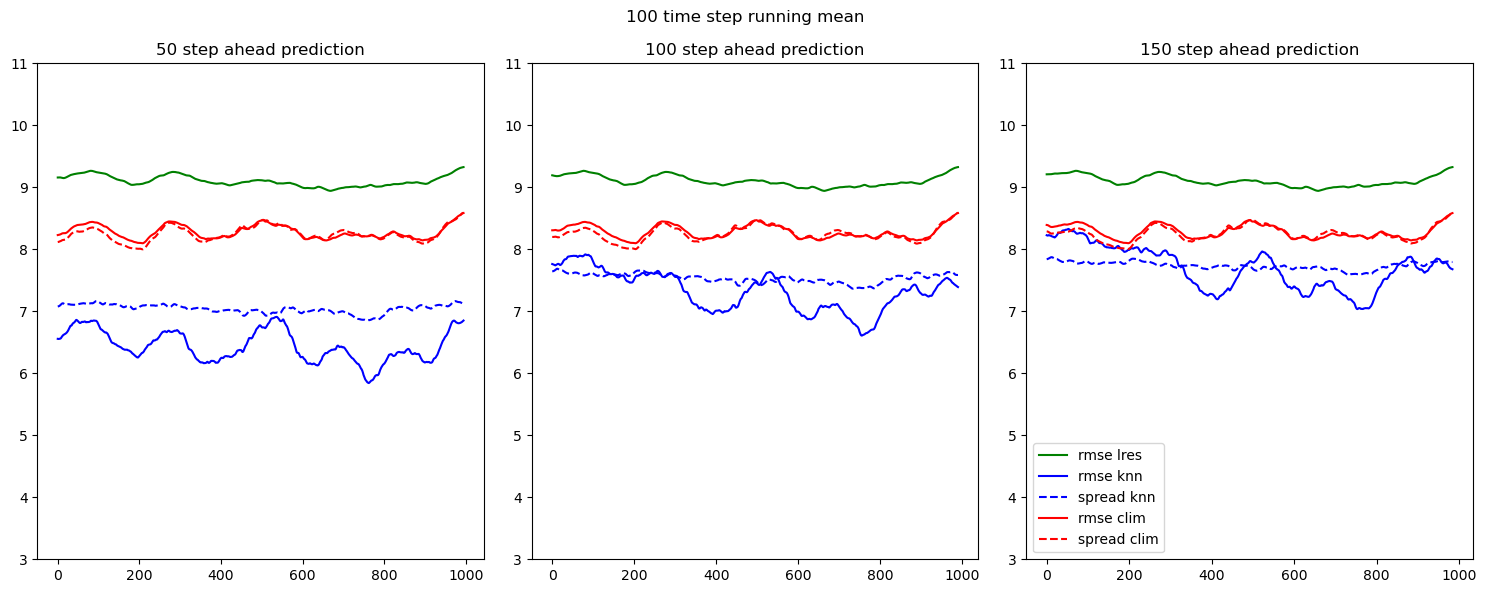

In [34]:
from scipy.ndimage.filters import uniform_filter1d
running_mean = 100
n = 90000
spinup = 1001
spacing = 10

ks = [50, 100, 150]
fig, axes = plt.subplots(1,3, figsize=(15, 6))  # Adjust the figsize as needed

for i, k in enumerate(ks):
    X_train, Y_train, X_test, Y_test, Y_lres = generate_data(n, k, spinup, spacing, lres=True)
    n_ens = 100
    ens_spread_knn, ens_rmse_knn, ens_spread_clm, ens_rmse_clm, ens_rmse_lres = ensemble(n_ens, X_train, Y_train, X_test, Y_test, Y_lres)

    axes[i].set_ylim(3, 11)
    axes[i].set_title(f'{k} step ahead prediction')
    axes[i].plot(uniform_filter1d(ens_rmse_lres, size=running_mean), 'g')
    axes[i].plot(uniform_filter1d(ens_rmse_knn, size=running_mean), 'b')
    axes[i].plot(uniform_filter1d(ens_spread_knn, size=running_mean), '--b')
    axes[i].plot(uniform_filter1d(ens_rmse_clm, size=running_mean),'r')
    axes[i].plot(uniform_filter1d(ens_spread_clm, size=running_mean), '--r')

plt.suptitle(f'{running_mean} time step running mean')
plt.legend(('rmse lres', 'rmse knn','spread knn','rmse clim','spread clim'))
plt.tight_layout()

# Latent space

## PCA

In [4]:
k = 150
n = 90000
spinup = 1001
spacing = 10

X_train, Y_train, X_test, Y_test, Y_lres = generate_data(n, k, spinup, spacing)

In [39]:
from sklearn.decomposition import PCA

# Compute PCA
pca = PCA()
X_transformed = pca.fit_transform(X_train)

In [40]:
# Function to reconstruct data using first l components
def reconstruct_data(transformed_data, pca, l):
    return np.dot(transformed_data[:, :l], pca.components_[:l, :]) + pca.mean_

def reconstruction_error(original_data, reconstructed_data):
    return np.mean(np.square(original_data - reconstructed_data))

def plot_image(x):
    x = x.reshape((65,65))
    plt.imshow(x)


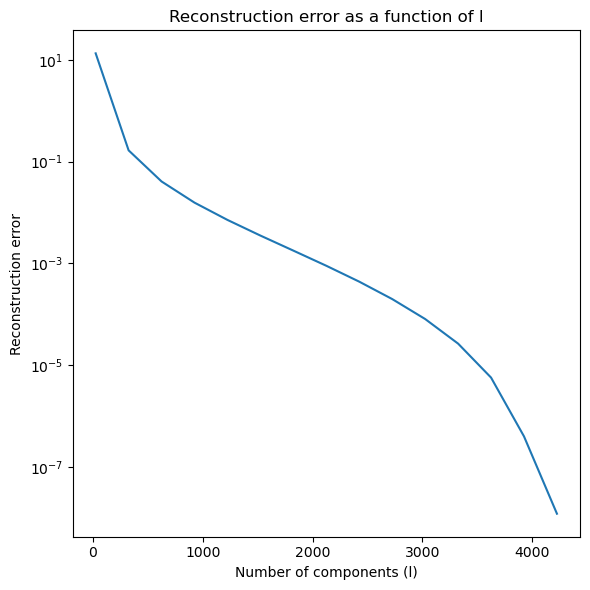

In [79]:
# Range of l values (number of components)
l_values = np.arange(25, 4226, 300) #100, 500, 1000, 2000, 3000, 4225] #range(1, min(X_train.shape) + 1)  # l ranges from 1 to s
errors = []

for l in l_values:
    reconstructed_data = reconstruct_data(X_transformed, pca, l)
    error = reconstruction_error(X_train, reconstructed_data)
    errors.append(error)

# Plotting the reconstruction errors

plt.figure(figsize=(6,6))
plt.semilogy(l_values, errors)
plt.xlabel('Number of components (l)')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error as a function of l')
plt.tight_layout()
plt.show()


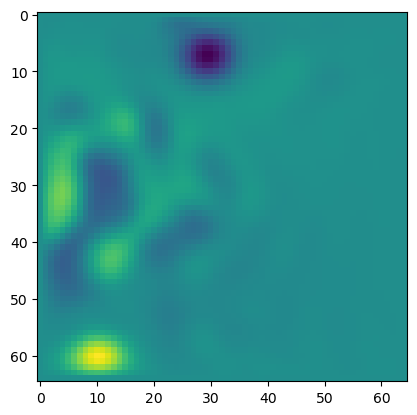

In [41]:
l = 256
X_PCA = reconstruct_data(X_transformed, pca, l)
error = reconstruction_error(X_train, X_PCA)

plot_image(X_PCA[1000])

## Autoencoder

In [5]:
k = 150
n = 90000
spinup = 1001
spacing = 10

X_train, Y_train, X_test, Y_test, Y_lres = generate_data(n, k, spinup, spacing)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert to tensor
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
batch_size = 64  # You can choose a batch size that fits your needs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Linear

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(True),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(True),
            nn.Linear(hidden_size[1], hidden_size[2]),
            )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size[2], hidden_size[1]),
            nn.ReLU(True),
            nn.Linear(hidden_size[1], hidden_size[0]),
            nn.ReLU(True),
            nn.Linear(hidden_size[0], input_size),
            )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

Epoch [1/20], Loss: 29.0211
Epoch [2/20], Loss: 11.2137
Epoch [3/20], Loss: 8.1243
Epoch [4/20], Loss: 6.6786
Epoch [5/20], Loss: 5.7605
Epoch [6/20], Loss: 5.1224
Epoch [7/20], Loss: 4.7727
Epoch [8/20], Loss: 4.3968
Epoch [9/20], Loss: 4.1820
Epoch [10/20], Loss: 3.9804
Epoch [11/20], Loss: 3.8247
Epoch [12/20], Loss: 3.7140
Epoch [13/20], Loss: 3.5278
Epoch [14/20], Loss: 3.4629
Epoch [15/20], Loss: 3.3969
Epoch [16/20], Loss: 3.3038
Epoch [17/20], Loss: 3.2650
Epoch [18/20], Loss: 3.1703
Epoch [19/20], Loss: 3.0707
Epoch [20/20], Loss: 3.0465


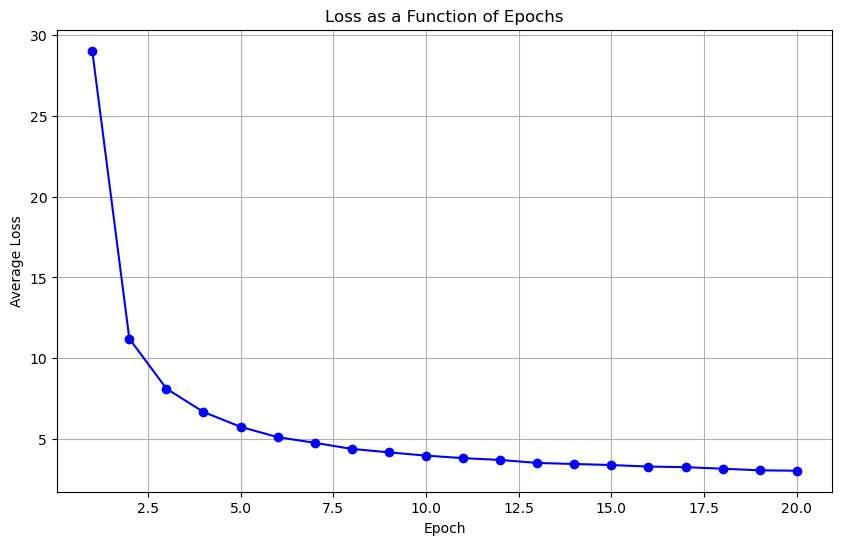

In [12]:
model = Autoencoder(input_size=4225, hidden_size=(500,200,100))  # Example sizes
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.apply(init_weights)

num_epochs = 20
loss_values = []

for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data  # Assuming the dataset returns a tuple (image, label)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='blue')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()


### Convolutional (U-net)

In [33]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.image_size = 65
        kernel_size = 3
        padding=1

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, padding=0),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, padding=1),
            nn.Flatten(start_dim=2),
            )
        self.decoder = nn.Sequential(
            nn.Unflatten(2,(16, 16)),
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2), # 1
            )
        
    def forward(self, x):
        x = x.view(-1, 1, self.image_size, self.image_size)
        x = self.encoder(x)
        #print("Latent",x.shape)
        x = self.decoder(x)
        x = x.view(x.size(0),-1)
        return x


In [36]:
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#model.apply(init_weights)

num_epochs = 50
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data  # Assuming the dataset returns a tuple (image, label)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 82.5633
Epoch [1/50], Loss: 84.2716
Epoch [1/50], Loss: 77.8066
Epoch [1/50], Loss: 79.1732
Epoch [1/50], Loss: 76.3957
Epoch [1/50], Loss: 74.6317
Epoch [1/50], Loss: 133.6854
Epoch [1/50], Loss: 73.0470
Epoch [1/50], Loss: 80.3568
Epoch [1/50], Loss: 80.7799
Epoch [1/50], Loss: 81.5733
Epoch [1/50], Loss: 82.3755
Epoch [1/50], Loss: 79.7823
Epoch [1/50], Loss: 81.4607
Epoch [1/50], Loss: 82.2270
Epoch [1/50], Loss: 81.6290
Epoch [1/50], Loss: 82.8545
Epoch [1/50], Loss: 82.4365
Epoch [1/50], Loss: 78.9501
Epoch [1/50], Loss: 81.5168
Epoch [1/50], Loss: 76.4511
Epoch [1/50], Loss: 68.2608
Epoch [1/50], Loss: 69.8746
Epoch [1/50], Loss: 58.2651
Epoch [1/50], Loss: 62.8855
Epoch [1/50], Loss: 61.7379
Epoch [1/50], Loss: 52.6793
Epoch [1/50], Loss: 56.3525
Epoch [1/50], Loss: 50.0943
Epoch [1/50], Loss: 51.9756
Epoch [1/50], Loss: 50.4023
Epoch [1/50], Loss: 47.9313
Epoch [1/50], Loss: 49.6269
Epoch [1/50], Loss: 46.4341
Epoch [1/50], Loss: 48.5670
Epoch [1/50], Loss:

KeyboardInterrupt: 

## Evaluation

In [42]:
# Ensure the model is in evaluation mode
model.eval()

# Convert X_train to a torch tensor if it's not already
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# If your model and data are on different devices (CPU vs. GPU), move the data to the same device as the model
# For example, if your model is on GPU:
# X_train_tensor = X_train_tensor.to("cuda")

# Disable gradient computation
with torch.no_grad():
    # Pass the data through the model
    X_AE_tensor = model(X_train_tensor)

# If you need the output as a NumPy array
X_AE = X_AE_tensor.cpu().numpy()  # Make sure to move the tensor back to CPU if it's on GPU


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 18633195520 bytes.

In [45]:
random_index = np.random.randint(len(X_train))
image_shape = (65, 65)  # Replace with the actual shape of your images
img_train = X_train[random_index].reshape(image_shape)
img_pca = X_PCA[random_index].reshape(image_shape)
img_ae =  model(X_train[random_index:random_index+1])[0].reshape(image_shape)

#vmin = min(X_train.min(), X_PCA.min(), X_AE.min())
#vmax = max(X_train.max(), X_PCA.max(), X_AE.max())


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_train, cmap='viridis')#, vmin=vmin, vmax=vmax)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_pca- img_train, cmap='viridis')#, vmin=vmin, vmax=vmax)
er_PCA = np.round(reconstruction_error(img_train, img_pca),2)
axes[1].set_title(f'PCA Image\n{str(er_PCA)}')
axes[1].axis('off')

axes[2].imshow(img_ae-img_train, cmap='viridis')#, vmin=vmin, vmax=vmax)
er_AE = np.round(reconstruction_error(img_train, img_ae), 2)
axes[2].set_title(f'Autoencoder Image\n{str(er_AE)}')
axes[2].axis('off')

plt.show()

TypeError: view() takes from 0 to 2 positional arguments but 4 were given